In [1]:
import os
os.chdir(os.path.abspath(".."))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataio import load_metadataset, load_rmses
from metamodel import build_baseline, build_regression_topline

from sklearn.feature_selection import SelectFpr, VarianceThreshold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [3]:
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    print(f"--- Analysing {feature_set} features ---")
    meta_X, meta_y = load_metadataset(feature_set, problem_type="regression")
    total_features = meta_X.shape[1]

    variance_selector = VarianceThreshold((1e-5)**2).fit(meta_X)
    meta_X_threshold = meta_X[variance_selector.get_feature_names_out()]
    threshold_features = meta_X_threshold.shape[1]

    removed_features = total_features - threshold_features
    print(f"{removed_features} feature(s) removed due to low variance ({100 * removed_features / total_features:.2f}%)")

    anova_selector = SelectFpr(alpha=0.05).fit(meta_X_threshold, meta_y)
    meta_X_final = meta_X_threshold[anova_selector.get_feature_names_out()]
    final_features = meta_X_final.shape[1]

    print(f"{final_features} out of {threshold_features} features are significant ({(100 * final_features / threshold_features):.2f}%)")

    print("Best ranked features:")
    for n, i in enumerate(np.argsort(anova_selector.pvalues_)[:10]):
        print(f"\t{n+1}. {meta_X_threshold.columns[i]}: {100 - 100 * anova_selector.pvalues_[i]:.5f}% confidence")

    print("")
    


--- Analysing catch22 features ---
0 feature(s) removed due to low variance (0.00%)
40 out of 177 features are significant (22.60%)
Best ranked features:
	1. q1_SP_Summaries_welch_rect_centroid: 100.00000% confidence
	2. median_CO_trev_1_num: 100.00000% confidence
	3. q3_CO_trev_1_num: 100.00000% confidence
	4. mean_CO_trev_1_num: 100.00000% confidence
	5. std_CO_trev_1_num: 99.99962% confidence
	6. q1_FC_LocalSimple_mean1_tauresrat: 99.99596% confidence
	7. median_SP_Summaries_welch_rect_centroid: 99.99551% confidence
	8. mean_SP_Summaries_welch_rect_centroid: 99.99424% confidence
	9. median_SB_TransitionMatrix_3ac_sumdiagcov: 99.98705% confidence
	10. number_examples: 99.98344% confidence

--- Analysing minimal features ---
0 feature(s) removed due to low variance (0.00%)
4 out of 72 features are significant (5.56%)
Best ranked features:
	1. number_examples: 99.98344% confidence
	2. median_standard_deviation: 97.78234% confidence
	3. median_variance: 96.64475% confidence
	4. min_root

In [4]:
print("--- Analysing label features ---")
meta_X, meta_y = load_metadataset("minimal", problem_type="regression")
label_columns = [c for c in meta_X.columns if c.startswith("label_")]
meta_X = meta_X[label_columns]

anova_selector = SelectFpr(alpha=0.05).fit(meta_X, meta_y)
for n, i in enumerate(np.argsort(anova_selector.pvalues_)):
    print(f"{n+1}. {meta_X.columns[i]}: {100 - 100 * anova_selector.pvalues_[i]:.5f}% confidence")


--- Analysing label features ---
1. label_median: 22.07641% confidence
2. label_minimum: 16.13110% confidence
3. label_mean: 11.91450% confidence
4. label_maximum: 7.71725% confidence
5. label_standard_deviation: 7.28307% confidence
6. label_root_mean_square: 3.53245% confidence


In [7]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    accs = np.empty(5)
    for i in range(5):
        results = pd.read_csv(f"./results/regression_label_{feature_set}_xgb_{i+1}.csv")
        accs[i] = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * np.mean(accs):.5f}%")

--- Best estimator accuracies ---
catch22: 32.25806%
minimal: 37.09677%
efficient: 37.09677%
comprehensive: 38.70968%


In [14]:
results = dict()
rmses = load_rmses()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"./results/regression_label_{feature_set}_xgb_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5

    results[feature_set] = rmse

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(rmses)
results["drcif"] = rmses.loc["DrCIF"].sort_index().to_numpy()
results["freshprince"] = rmses.loc["FreshPRINCE"].sort_index().to_numpy()
results["topline"] = build_regression_topline(rmses)

results = pd.DataFrame(results).set_index("datasets")
results_normalized = ((results.T - results.T.mean()) / results.T.std()).T
results_normalized

,catch22,minimal,efficient,comprehensive,baseline,drcif,freshprince,topline
datasets,,,,,,,,
AcousticContaminationMadrid-no-missing,0.205687,-1.142252,1.096579,1.096579,0.748693,0.279216,-1.142252,-1.142252
AluminiumConcentration,-0.270427,-0.270427,-0.270427,-0.270427,0.570859,-0.270427,2.123161,-1.341884
AppliancesEnergy,-0.312966,2.222006,-0.312966,-0.312966,0.627820,-0.312966,-0.798981,-0.798981
BIDMC32HR,-0.578392,-0.578392,-0.578392,-0.578392,2.248466,0.501566,0.141929,-0.578392
BIDMC32RR,-0.648479,-0.648479,-0.648479,-0.648479,1.782144,1.273420,0.223985,-0.685634
...,...,...,...,...,...,...,...,...
TetuanEnergyConsumption,-0.312392,-0.312392,-0.312392,-0.312392,2.469810,-0.453925,-0.312392,-0.453925
VentilatorPressure,0.552759,-0.868100,-0.868100,-0.868100,1.718915,0.647966,0.552759,-0.868100
WaveDataTension,-0.487968,-0.447681,1.579011,1.579011,-0.106199,-0.487968,-0.814103,-0.814103


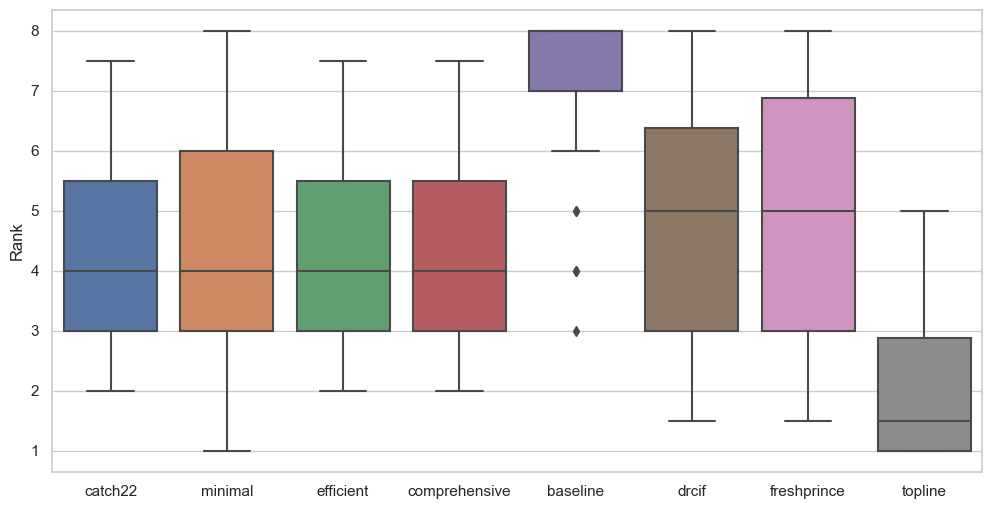

In [15]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=results.rank(axis=1), ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Rank")

plt.show()

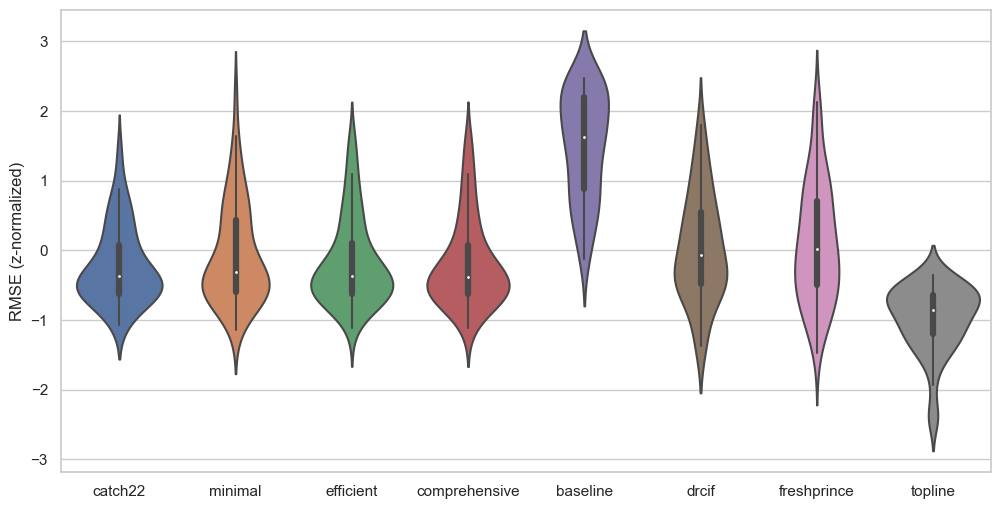

In [16]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE (z-normalized)")

plt.show()

Null hypothesis rejected (p-value 0.00000)


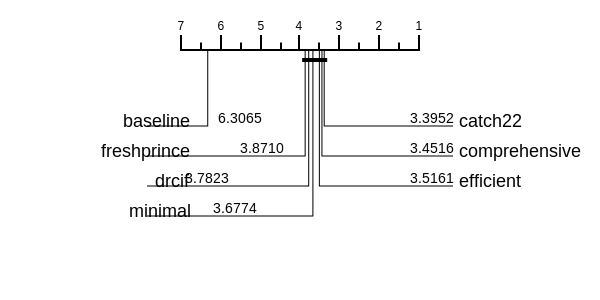

In [18]:
from scipy.stats import chi2, wilcoxon
import networkx as nx
import drawsvg as draw

def hypothesis_tests(df, alpha=0.05):
    N, M = df.shape

    df_ranks = df.rank(axis=1)
    avranks = df_ranks.mean()
    
    friedman_statistic = (12*N / (M*(M+1))) * (np.sum(avranks**2) - M*(M+1)**2 / 4)
    friedman_p = 1 - chi2.cdf(friedman_statistic, M - 1)
    if friedman_p > alpha:
        raise AssertionError(f"Cannot reject null hypothesis (p-value: {friedman_p:.5f})")
    
    print(f"Null hypothesis rejected (p-value {friedman_p:.5f})")

    wilcoxon_p = np.empty((M, M))
    for i in range(M):
        for j in range(M):
            if i == j:
                wilcoxon_p[i,j] = 1.0
            else:
                _, wilcoxon_p[i,j] = wilcoxon(
                    df[df.columns[i]],
                    df[df.columns[j]],
                    zero_method="pratt",
                )
    
    G = nx.Graph()
    G.add_nodes_from(df.columns)

    hypothesis = list()
    for i in range(M):
        for j in range(i+1, M):
            hypothesis.append((wilcoxon_p[i,j], i, j, True))
    hypothesis = sorted(hypothesis)

    # Holm correction
    for i in range(len(hypothesis)):
        new_alpha = alpha / (len(hypothesis) - i)
        if hypothesis[i][0] < new_alpha:
            hypothesis[i] = (hypothesis[i][0], hypothesis[i][1], hypothesis[i][2], False)
        else:
            break

    for h in hypothesis:
        if h[3]:
            G.add_edge(df.columns[h[1]], df.columns[h[2]])

    return avranks, [clique for clique in nx.find_cliques(G) if len(clique) > 1]


def cd_diagram(df, alpha=0.05):
    IMG_W = 600
    IMG_H = 300
    MAINLINE_W = IMG_W * 0.4
    MAINLINE_Y = 50 - (IMG_H / 2)
    MAINLINE_STROKE = 2
    TICK_H = 15
    MODELLINE_STROKE = MAINLINE_STROKE / 2
    MODEL_YSTART = MAINLINE_Y + 60
    MODEL_XSTART = (MAINLINE_W / 2) - 10
    MODEL_VGAP = 30
    CLIQUE_VGAP = 10

    avranks, cliques = hypothesis_tests(df, alpha)
    _, M = df.shape

    canva = draw.Drawing(IMG_W, IMG_H, origin='center', font_family="Arial")

    canva.append(draw.Line(
        -MAINLINE_W / 2, MAINLINE_Y, 
        MAINLINE_W / 2, MAINLINE_Y, 
        stroke="black", 
        stroke_width=MAINLINE_STROKE
    ))

    for i, rank in enumerate(range(M, 0, -1)):
        rank_tick_X = (-MAINLINE_W / 2) + (i/(M-1)) * (MAINLINE_W)
        if rank_tick_X < 0:
            rank_tick_X += MAINLINE_STROKE / 2
        else:
            rank_tick_X -= MAINLINE_STROKE / 2

        canva.append(draw.Line(
            rank_tick_X, MAINLINE_Y,
            rank_tick_X, MAINLINE_Y - TICK_H,
            stroke="black",
            stroke_width=MAINLINE_STROKE,
        ))

        canva.append(draw.Text(
            f"{rank}", font_size=12,
            x=rank_tick_X, y=MAINLINE_Y - TICK_H - 5,
            text_anchor="middle"
        ))

        if rank != 1:
            half_tick_X = (-MAINLINE_W / 2) + ((i + 0.5)/(M-1)) * (MAINLINE_W)
            if half_tick_X < 0:
                half_tick_X += MAINLINE_STROKE / 2
            else:
                half_tick_X -= MAINLINE_STROKE / 2

            canva.append(draw.Line(
                half_tick_X, MAINLINE_Y,
                half_tick_X, MAINLINE_Y - TICK_H / 2,
                stroke="black",
                stroke_width=MAINLINE_STROKE,
            ))

    sorted_avranks = avranks.sort_values()
    half = len(sorted_avranks) // 2
    right = sorted_avranks[:half]
    left = sorted_avranks[half:][::-1]

    for i, (model, rank) in enumerate(right.items()):
        rank_Y = MODEL_YSTART + i * MODEL_VGAP

        rank_text = draw.Text(
            f"{rank:.4f}", font_size=14, dominant_baseline="hanging",
            x=MODEL_XSTART, y=rank_Y, 
        )
        rank_text.append(draw.TSpan(
            model, dx=5, font_size=18
        ))
        canva.append(rank_text)

        rank_pos = (-MAINLINE_W / 2) + ((M - rank) / (M - 1)) * (MAINLINE_W)

        g = draw.Group(stroke="black", stroke_width=MODELLINE_STROKE, fill='none')
        p = draw.Path()
        p.M(rank_pos, MAINLINE_Y)
        p.L(rank_pos, rank_Y + 16)
        p.L(MODEL_XSTART + 43, rank_Y + 16)
        g.append(p)
        canva.append(g)

    for i, (model, rank) in enumerate(left.items()):
        rank_Y = MODEL_YSTART + i * MODEL_VGAP

        rank_text = draw.Text(
            model, font_size=18, dominant_baseline="hanging",
            x=-MODEL_XSTART, y=rank_Y, text_anchor="end"
        )
        rank_text.append(draw.TSpan(
            f"{rank:.4f}", dx=5, font_size=14
        ))
        canva.append(rank_text)

        rank_pos = (-MAINLINE_W / 2) + ((M - rank) / (M - 1)) * (MAINLINE_W)

        g = draw.Group(stroke="black", stroke_width=MODELLINE_STROKE, fill='none')
        p = draw.Path()
        p.M(rank_pos, MAINLINE_Y)
        p.L(rank_pos, rank_Y + 16)
        p.L(-MODEL_XSTART - 43, rank_Y + 16)
        g.append(p)
        canva.append(g)
    
    clique_lines = list()
    for clique in cliques:
        clique_ranks = sorted_avranks[clique]
        clique_lines.append((np.min(clique_ranks), np.max(clique_ranks)))

    for i, (rank_high, rank_low) in enumerate(sorted(clique_lines)):
        clique_line_Y = MAINLINE_Y + (i+1) * CLIQUE_VGAP
        clique_start_X = (-MAINLINE_W / 2) + ((M - rank_low) / (M - 1)) * (MAINLINE_W)
        clique_end_X = (-MAINLINE_W / 2) + ((M - rank_high) / (M - 1)) * (MAINLINE_W)

        canva.append(draw.Line(
            clique_start_X - 3, clique_line_Y,
            clique_end_X + 3, clique_line_Y,
            stroke="black",
            stroke_width=4,
        ))                                

    return canva
    
cd_diagram(results[["baseline", "catch22", "minimal", "efficient", "comprehensive", "drcif", "freshprince"]])